# Deep RL Banana Agent - How it works and what it does

---

Unity ML-Agents Toolkit provides a variety of open-source 3D environments that can be used to train an intelligent agent. In this project we'll look at the Banana Agent, whose world is a square box, and whose objective is to collect as many yellow bananas as possible while actively avoiding blue ones. In this project I'll solve the Banana Agent environment by training an intelligent agent to gather bananas.

### Learning Algorithm

The learning algorithm being used is the Double DQN. The concept of double q learning was introduced to address a problem of overoptimism with q-learning, and to overcome this, the general idea is to use the target network to decide the value of taking the next action in the next state, in the Bellman equation we use to create the target q values. 
- https://arxiv.org/pdf/1509.06461.pdf
- https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682

I wanted to try improving the standard DQN and the Double DQN looked like a good option to implement, so I went with it and was impressed with the results. The Double DQN agent trained faster and with higher scores than the standard DQN.

The agent requires several parameters in order to be trained.  Through a process of trial and error I decided on the following. Some are still default from the lunar lander code I adapted for the banana environment, and others I've tweaked a bit to better suit the banana environment.
- BUFFER_SIZE = 50000     
Replay buffer size, the number of states to remember and select from when creating a training batch.
- BATCH_SIZE = 64         
The number of states seen per training batch.
- GAMMA = 0.99            
Discount factor used in the bellman equation when creating target q values.
- TAU = 1e-3              
For soft update of target parameters, when copying local network into target.
- LR = 0.001              
It's the default learning rate for adam optimizer.
- UPDATE_EVERY = 4        
How many environment steps to take until updating the network. I'm sticking with 4 as suggested in previous exercises.

The neural network being used is a MLP style network with 3 fully connected layers. Its input size is the length of the state vector (the actual size is configurable as explained in the cells below), and its output size is the number of actions available to the agent.
  - (fc1): Linear(in_features=37 (configurable parameter), out_features=256, bias=True)
  - (fc2): Linear(in_features=256, out_features=256, bias=True)
  - (fc3): Linear(in_features=256, out_features=4, bias=True)
  
After a few runs of trial and error I found a network of this size was performing well. While experimenting I tried models with more and less capacity and ultimately found this was performing well.

### Ideas for Future Work
I'd really like to try the 'from pixels' version of this environment like they did in the DQN paper. I think the concept is a pretty simple extension of what I've already done, the model should be updated to accept raw pixels into a few layers of Conv2d, flattened, and then passed through fully connected as is done now. In the DQN paper they stack 4 frames as the input to the conv net which inspired me to experiment with something similar when implementing an agent for the banana environment.

The Dueling DQN looks interesting as well, I think that would be a relatively easy upgrade to make to the model. Essentially you add branching paths in the model so it can learn state value and advantage separately, which is helpful in situations where certain actions have no meaningul effect on the environment. That is my understanding, I would like to learn more about it any try to implement it. The blog post mentioned earlier has some sample code in tensorflow that I was learning from. 

Another approach I'd like to try is with an LSTM, I'm not sure how well this would work and I haven't exactly planned it out, but I think you could model the agent's time in the environment as a sequence of events and provide that to an LSTM to find temporal relationships. You might have to rethink the replay buffer to do this with an LSTM, I'm not sure what the standard approach looks like but it's fun to think about.

### Train the agent

In the code cell below we train the agent for a number of episodes using the Unity environment. The agent will train until it can achieve an average score of 15 or higher over the last 100 episodes. The agent was implemented with the ability to 'look back' a few steps by including prior states in the training state, and this was inspired by the DQN paper where their 'learn by pixels' approach stacked the current frame plus the last 3 as input to the conv net. My model works similarly by exposing prior states during training. 

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.54	Actual Score:0.000
Episode 200	Average Score: 2.17	Actual Score:1.000
Episode 300	Average Score: 4.43	Actual Score:6.000
Episode 400	Average Score: 7.58	Actual Score:9.000
Episode 500	Average Score: 10.75	Actual Score:16.00
Episode 600	Average Score: 11.72	Actual Score:16.00
Episode 700	Average Score: 13.32	Actual Score:14.00
Episode 800	Average Score: 14.66	Actual Score:10.00
Episode 900	Average Score: 14.77	Actual Score:14.00
Episode 1000	Average Score: 14.85	Actual Score:17.00
Episode 1009	Average Score: 15.00	Actual Score:16.00
Environment solved in 909 episodes!	Average Score: 15.00	Actual Score:16.00


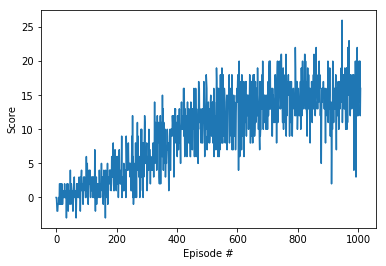

In [1]:
from dqn_agent import Agent
import Deep_Q_Network as dqn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

brain_name, env, env_info, state, state_size, action_size = dqn.new_unity_environment()

# inspired by the DQN paper, I tried including prior episodes to train the model
look_back_x_episodes = 4
state_size = state_size * look_back_x_episodes + (5 * look_back_x_episodes)

# even though this environment is 'solved' with an average score of 13, this agent 
# can do a little better so it will train until 15
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
scores = dqn.dqn_train(agent, env, brain_name, state_size)
env.close()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()



### Watch a trained agent!

Run the code cell below to watch a trained agent in the Unity environment. In this cell you can also see the experimental training state being used, which includes the last few states plus the action and reward that were taken in those states. Including the reward in the training data actually lowered overall performance by a point, but it was an interesting exercise to try so I kept it for the submission, if only to show that it's not a great idea. Including prior states did help the agent train more quickly, so now to use the trained agent we need to build up the same state in order to choose the next action.

Run the next code cell to see the trained agent in action!

In [1]:
from dqn_agent import Agent
from collections import deque
import Deep_Q_Network as dqn
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
plt.ion()

brain_name, env, env_info, state, state_size, action_size = dqn.new_unity_environment()

look_back_x_episodes = 4
state_size = state_size * look_back_x_episodes + (5 * look_back_x_episodes)

# load the weights for the model that was trained to 
agent = Agent(state_size=state_size, action_size=action_size)
agent.qnetwork_local.load_state_dict(torch.load('./15.00_checkpoint.pth'))


state = deque(maxlen=state_size)   # init state with all zeros
[state.append((0)) for _ in range(state_size)] 
one_hot_actions = [0 for i in range(agent.action_size)]

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
_state = env_info.vector_observations[0]           # get the current state
state.extend(_state)                               # the training state holds a few prior experiences
state.append((0))                                  # plus the current reward
state.extend(one_hot_actions)                      # and the action taken
score = 0                                          # initialize the score
while True:
    state_np = np.asarray(state)
    action = int(agent.act(state_np))              # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    
    # roll over the state to next time step
    one_hot_actions[action] = 1  # let the network know what action was just taken
    state.extend(next_state)     # add the next environment state to the training state
    state.append((reward))       # add the reward to the training state
    one_hot_actions[action] = 0  # reset action vector done
    state.extend(one_hot_actions)# add the action to the training state
    
    score += reward                                # update the score
    if done:                                       # exit loop if episode finished
        env.close()
        break
    
print("Score: {}".format(score))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Score: 14.0
